In [1]:
#https://www.xignite.com/Product/global-interest-rates#/productoverview 
#https://fiscaldata.treasury.gov/api-documentation/

In [370]:
#bring dependencies
from IPython.display import display
from IPython.display import display, HTML
from IPython.display import HTML
from pprint import pprint
from prettytable import PrettyTable
from tqdm import tqdm
from plotly.subplots import make_subplots
from config import api_key_bls
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import ipywidgets as widgets
import plotly.offline as pyo
import plotly as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import requests
import json
import os
import scipy.stats as st
from IPython.display import display, HTML
import seaborn as sns


In [371]:
# The url for BLS API v2
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(api_key_bls)


BDS0000000000000000110101LQ5 - Business Employment Dynamics
Business Employment Dynamics data are quarterly series of gross job gains and gross job losses statistics for the entire economy. These data track changes in employment at the establishment level, and thus provide a picture of the dynamics underlying aggregate net employment growth statistics.

- 1st plot the line graphic for jobs gain/loss
- 2nd calculated the mean and median for jobs gain/loss
- plot a bar graphic
- top 10 and bottom 10 jobs 2031 forecast


SMU19197802023800001 - State and Area Employment, Hours, and Earnings
The Current Employment Statistics (CES) program is a monthly survey conducted by the Bureau of Labor Statistics. It is a federal and state cooperative program that provides employment, hours, and earnings estimates for states and metropolitan areas based on payroll records of business establishments.

LAUCN281070000000003 - Local Area Unemployment Statistics Overview
The Local Area Unemployment Statistics (LAUS) program is a federal-state cooperative effort in which monthly estimates of total employment and unemployment are prepared for over 7,600 areas

JLU00000000HIL - Job Openings and Labor Turnover Survey (SIC basis)
These data serve as demand-side indicators of labor shortages at the national level. Prior to JOLTS, there was no economic indicator of the unmet demand for labor with which to assess the presence or extent of labor shortages in the United States. The availability of unfilled jobs—the job openings rate—is an important measure of the tightness of job markets, parallel to existing measures of unemployment.

NCU5306633300003 - National Compensation - Discontinued Series (SIC and Census of Population)
produces quarterly indexes measuring change over time in labor costs, Employment Cost Index (ECI), and quarterly data measuring level of average costs per hour worked, Employer Costs for Employee Compensation (ECEC).

In [372]:
#series
headers = {'Content-type': 'application/json'} #contains info about the message- such as destination

# Submit the list of series as data - payload actual data being transmitted over a network
data = json.dumps({"seriesid": ['BDS0000000000000000110001LQ5',#Business Employment Dynamic - jobs Gain
                                'BDS0000000000000000110004LQ5',#Business Employment Dynamic - jobs loss
                                'BDS0000000000000000120001LQ5',#Business Employment Dynamic - stablishment gain
                                'BDS0000000000000000120004LQ5'#Business Employment Dynamic - stablishment loss
                                
                               ], 
                   'startyear':'2010', 'endyear':'2023',
                   'catalog':True,
                   'annualaverage':True,
                   "registrationkey": api_key_bls}, indent=4)
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
p


<Response [200]>

In [373]:
#create a list to create a DF

list_columns= []


for series in json_data['Results']['series']:

     
    seriesId = series['seriesID']
    print(seriesId)
    
    if 'catalog' in series.keys():
        seasonality = series['catalog']['seasonality']
        survey_name = series['catalog']['survey_name']
        measure_data_type = series['catalog']['measure_data_type']
    
            
        if 'commerce_industry' in series['catalog'].keys():
            commerce_industry = series['catalog']['commerce_industry']
            
        else:
            commerce_industry = None
            
            
        if 'commerce_sector' in series['catalog'].keys():
            commerce_sector = series['catalog']['commerce_sector']
        else:
            commerce_sector = None
     
        if 'area' in series['catalog'].keys():
            area = series['catalog']['area']
        else:
            area = None
    
    
    
       # area= series['catalog']['area']
    else:
        seasonality = None
        survey_name = None
        measure_data_type = None
        commerce_industry = None
        commerce_sector = None
        area= None
    #add all variables & create a list to append to the list above
    
    
    for item in series['data']:
        year = item['year']
        period = item['period']
        periodName = item['periodName']
        value = item['value']
        
        
        list_columns.append([seriesId,seasonality,survey_name,measure_data_type,
                             commerce_industry,commerce_sector,area,year,period,periodName,value])
        
bls_df= pd.DataFrame(list_columns,columns=['seriesId','seasonality','survey_name','measure_data_type',
                             'commerce_industry','commerce_sector','area','year','period','periodName','value'])



bls_df.to_csv("bls.csv", index= False, header=True)





BDS0000000000000000110001LQ5
BDS0000000000000000110004LQ5
BDS0000000000000000120001LQ5
BDS0000000000000000120004LQ5


In [374]:
bed_df = bls_df.loc[(bls_df['seriesId'] == 'BDS0000000000000000110001LQ5') |
                     (bls_df['seriesId'] == 'BDS0000000000000000110004LQ5') ]
#                      (bls_df['seriesId'] == 'BDS0000000000000000120001LQ5') |
#                      (bls_df['seriesId'] == 'BDS0000000000000000120004LQ5')]
bed_df.to_csv("bed.csv", index=False, header=True)


In [375]:
#ties to https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5
BED=bed_df[['seriesId','survey_name','measure_data_type','commerce_industry','area','year','period','value']]


In [376]:
# replace the row name 'row1' with 'new_row1'
new_bed_df = bed_df.replace({'BDS0000000000000000110001LQ5':'jobs Gains',
                              'BDS0000000000000000110004LQ5':'jobs Losses'})
#                               'BDS0000000000000000120001LQ5': 'Stablishment Gains',
#                               'BDS0000000000000000120004LQ5': 'Stablishment Losses' })
                   

In [377]:
new_bed_df.columns

Index(['seriesId', 'seasonality', 'survey_name', 'measure_data_type',
       'commerce_industry', 'commerce_sector', 'area', 'year', 'period',
       'periodName', 'value'],
      dtype='object')

In [378]:
#change column value to Integer
new_bed_df['value'] = new_bed_df['value'].astype(int)


In [379]:
# pitot the data plot 
# https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5

new_bed_df_pivot = new_bed_df.pivot_table(index=['year'], columns='measure_data_type', values='value', aggfunc='sum')


Text(0.5, 1.0, 'Gross job for the total private sector in the U.S.(rounded to the nearest thousands)')

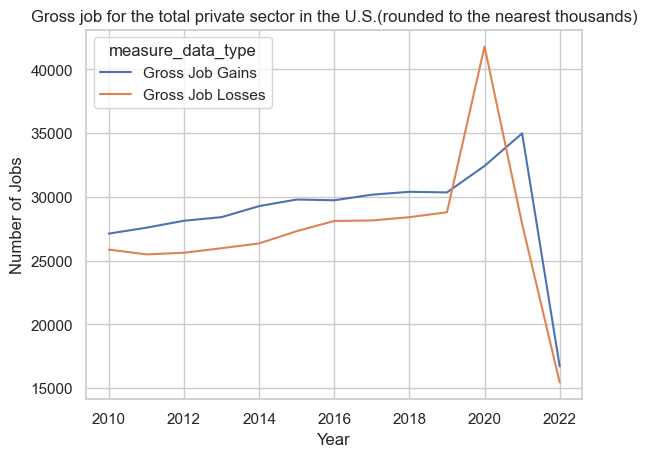

In [380]:

# plot the resulting DataFrame using the plot method
new_bed_df_pivot.plot(kind='line', ylabel='Number of Jobs', xlabel='Year', grid=True)
plt.title('Gross job for the total private sector in the U.S.(rounded to the nearest thousands)')

In [381]:
# https://data.bls.gov/timeseries/BDS0000000000000000110001LQ5
#file:///C:/Users/aumek/OneDrive/Desktop/Group%20Project%201/Project1_AU/fig_bed_plot.html
new_bed_df_pivot = new_bed_df.pivot_table(index=['year'], columns='measure_data_type', values='value', aggfunc='sum').reset_index()
fig_bed = px.line(new_bed_df_pivot, x='year', y=['Gross Job Gains', 'Gross Job Losses'])
fig_bed.update_traces(mode='lines+markers', hovertemplate='Year=%{x}<br>Value=%{y:.0f}<extra></extra>')
fig_bed.update_layout(title='Gross job for the total private sector in the U.S.',
                  xaxis_title='Year', yaxis_title='Number of Jobs', hovermode='x')
pio.write_html(fig_bed, file='fig_bed_plot.html', auto_open=True)
fig_bed.show()

In [250]:
new_bed_df_pivot

measure_data_type,year,Gross Job Gains,Gross Job Losses
0,2010,27113,25859
1,2011,27576,25484
2,2012,28122,25611
3,2013,28406,25967
4,2014,29271,26342
5,2015,29787,27303
6,2016,29729,28106
7,2017,30166,28145
8,2018,30394,28402
9,2019,30346,28788


In [360]:
#change column value to Integer
new_bed_df_pivot['Gross Job Gains'] = new_bed_df_pivot['Gross Job Gains'].astype(int)
new_bed_df_pivot['Gross Job Losses'] = new_bed_df_pivot['Gross Job Losses'].astype(int)
#new_bed_df_pivot['year'] = new_bed_df_pivot['year'].astype(int)

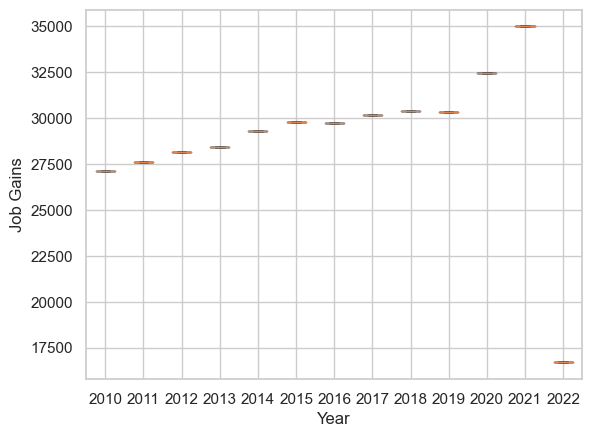

In [361]:
job_gain = new_bed_df_pivot["Gross Job Gains"]
year= new_bed_df_pivot['year']

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a list of the job gains data for each year
job_gains_data = [
   new_bed_df_pivot["Gross Job Gains"][new_bed_df_pivot['year'] == year]
    for year in new_bed_df_pivot['year']
]

# Plot the box plot
ax.boxplot(job_gains_data)

# Set the x-axis label and ticks
ax.set_xlabel('Year')
ax.set_xticklabels(new_bed_df_pivot['year'])

# Set the y-axis label
ax.set_ylabel('Job Gains')

# Show the plot
plt.show()


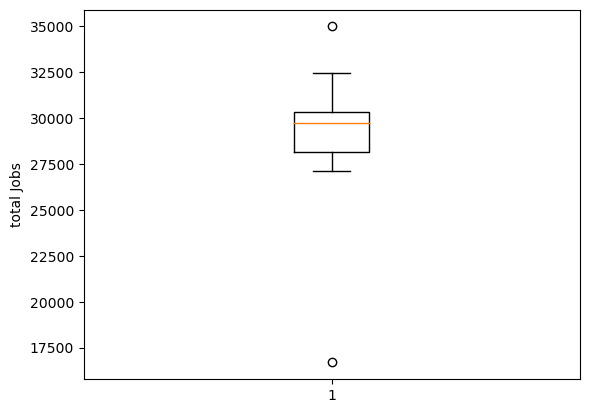

The average job gain 28846.62 between 2010-2022
The median job gain 29729.00 between 2010-2022
The lower quartile of Job Gains is: 28122.0
The upper quartile of Job Gains is: 30346.0
The interquartile range of Job Gains is: 2224.0
The the median of Job Gains is: 29729.0 
Values below 24786.0 could be outliers.
Values above 33682.0 could be outliers.


In [253]:
job_gains = new_bed_df_pivot["Gross Job Gains"]

fig1, ax1 = plt.subplots()
ax1.set_title('')
ax1.set_ylabel('total Jobs')
ax1.boxplot(job_gains)
plt.show()


 #  calculating measures of central tendency - Jobs gain_loss between 2010-2022
job_gains = new_bed_df_pivot["Gross Job Gains"]
    
mean_gain = np.mean(job_gains)

print(f"The average job gain {mean_gain:.2f} between 2010-2022")


median_gain = np.median(job_gains)


print(f"The median job gain {median_gain:.2f} between 2010-2022")


#quartile calculations
quartiles = job_gains.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq


print(f"The lower quartile of Job Gains is: {lowerq}")
print(f"The upper quartile of Job Gains is: {upperq}")
print(f"The interquartile range of Job Gains is: {iqr}")
print(f"The the median of Job Gains is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")



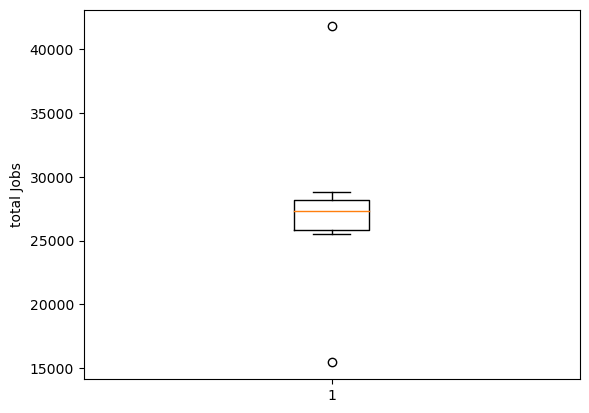

The average job loss 27316.00 between 2010-2022
The median job loss 27303.00 between 2010-2022
The lower quartile of Job Losses is: 25859.0
The upper quartile of Job Losses is: 28145.0
The interquartile range of Job Losses is: 2286.0
The the median of Job Losses is: 27303.0 
Values below 22430.0 could be outliers.
Values above 31574.0 could be outliers.


In [254]:
job_losses = new_bed_df_pivot["Gross Job Losses"]

fig1, ax1 = plt.subplots()
ax1.set_title('')
ax1.set_ylabel('total Jobs')
ax1.boxplot(job_losses)
plt.show()

 #  calculating measures of central tendency - Jobs gain_loss between 2010-2022

job_losses = new_bed_df_pivot["Gross Job Losses"]
    

mean_loss = np.mean(job_losses)

print(f"The average job loss {mean_loss:.2f} between 2010-2022")

median_loss = np.median(job_losses)

print(f"The median job loss {median_loss:.2f} between 2010-2022")


#quartile calculations
quartiles = job_losses.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq


print(f"The lower quartile of Job Losses is: {lowerq}")
print(f"The upper quartile of Job Losses is: {upperq}")
print(f"The interquartile range of Job Losses is: {iqr}")
print(f"The the median of Job Losses is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

In [255]:
#  calculating measures of central tendency - Jobs gain_loss between 2019-2021 - Covid peak
start_year = 2019
end_year = 2021
filtered_data = new_bed_df_pivot.loc[(new_bed_df_pivot['year'].astype(int) >= start_year) & (new_bed_df_pivot['year'].astype(int) <= end_year)]
mean_gain_covid = filtered_data['Gross Job Gains'].mean()
mean_loss_covid = filtered_data['Gross Job Losses'].mean()

print(f"During Covid USA experienced an average job gain {mean_gain_covid:.2f} and an average job loss {mean_loss_covid:.2f} between 2019-2021")

median_gain_covid = filtered_data['Gross Job Gains'].median()
median_loss_covid = filtered_data['Gross Job Losses'].median()

print(f"During Covid USA experienced a median job gain {median_gain_covid:.2f} and a median job loss {median_loss_covid:.2f} between 2019-2021")


During Covid USA experienced an average job gain 32583.67 and an average job loss 32818.67 between 2019-2021
During Covid USA experienced a median job gain 32425.00 and a median job loss 28788.00 between 2019-2021


In [256]:
 #  calculating measures of central tendency - Jobs gain_loss between 2010-2018 - excluding Covid pandemic

start_year = 2010
end_year = 2018
filtered_data = new_bed_df_pivot.loc[(new_bed_df_pivot['year'].astype(int) >= start_year) & (new_bed_df_pivot['year'].astype(int) <= end_year)]
mean_gain_wo_covid = filtered_data['Gross Job Gains'].mean()
mean_loss_wo_covid = filtered_data['Gross Job Losses'].mean()

print(f"During Covid USA experienced an average job gain {mean_gain_wo_covid:.2f} and an average job loss {mean_loss_wo_covid:.2f} between 2010-2018")

median_gain_wo_covid = filtered_data['Gross Job Gains'].median()
median_loss_wo_covid = filtered_data['Gross Job Losses'].median()

print(f"During Covid USA experienced a median job gain {median_gain_wo_covid:.2f} and a median job loss {median_loss_wo_covid:.2f} between 2010-2018")


During Covid USA experienced an average job gain 28951.56 and an average job loss 26802.11 between 2010-2018
During Covid USA experienced a median job gain 29271.00 and a median job loss 26342.00 between 2010-2018


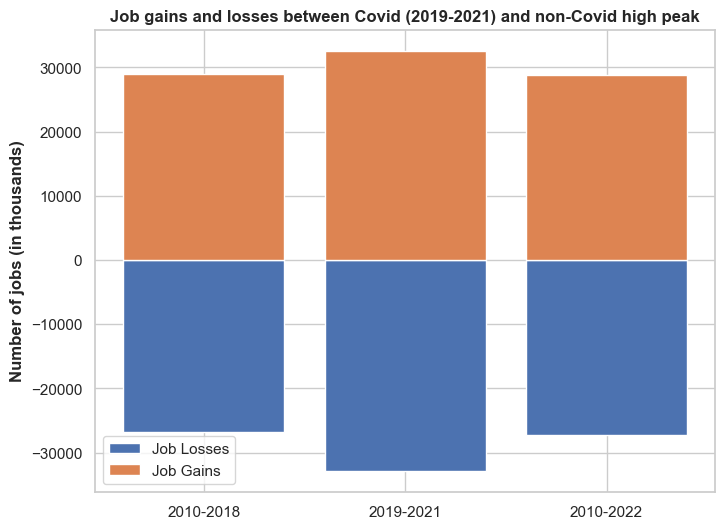

In [362]:
# Create bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(['2010-2018','2019-2021','2010-2022'], [ -mean_loss_wo_covid,-mean_loss_covid,-mean_loss,], label='Job Losses')
ax.bar(['2010-2018','2019-2021','2010-2022'], [mean_gain_wo_covid, mean_gain_covid, mean_gain], label='Job Gains')
ax.set_ylabel('Number of jobs (in thousands)',fontweight='bold')
ax.set_title('Job gains and losses between Covid (2019-2021) and non-Covid high peak',fontweight='bold' )
ax.legend()
plt.show()



In [382]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Data
x = [ '2010-2018', '2019-2021','2010-2022']
y1 = [mean_gain_wo_covid, mean_gain_covid,mean_gain ]
y2 = [-mean_loss_wo_covid, -mean_loss_covid,-mean_loss]

# Create traces
trace1 = go.Bar(x=x, y=y1, name='Job Gains')
trace2 = go.Bar(x=x, y=y2, name='Job Losses')

# Create layout
layout = go.Layout(title='Comparison of job gains and job losses between Covid (2019-2021) and non-Covid high peak',
                   xaxis={'title': 'Year Range'},
                   yaxis={'title': 'Number of jobs (in thousands)'},
                   hovermode='closest')

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)
pio.write_html(fig, file='fig_plot.html', auto_open=True)
fig.show()
# Show figure
#iplot(fig)


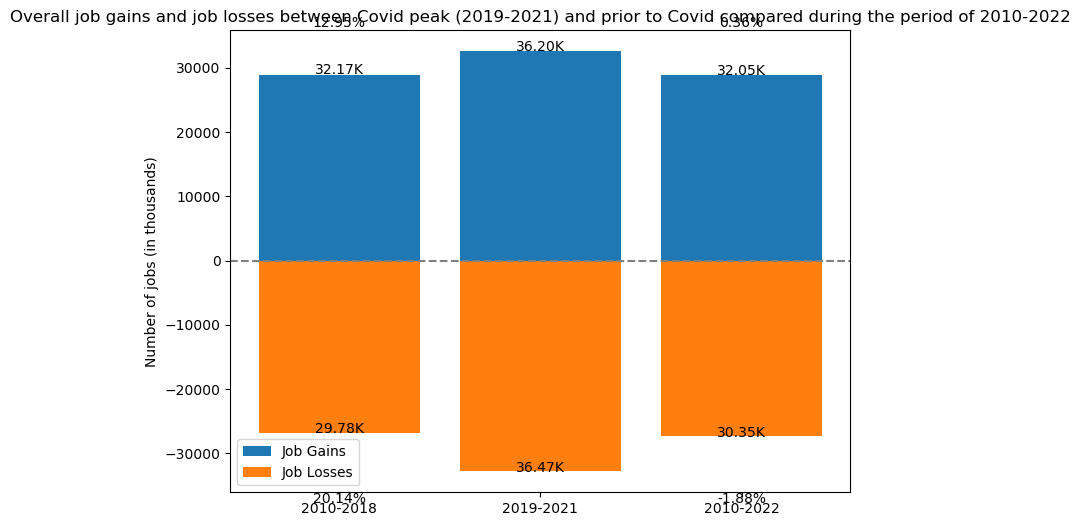

In [259]:
fig, ax = plt.subplots(figsize=(8, 6))
x_labels = [ '2010-2018', '2019-2021','2010-2022']

# Calculate the percentage changes - percentage_change = ((new_value - old_value) / old_value) * 100
gain_pct_changes = [((mean_gain_covid-mean_gain)/mean_gain)*100, 0, ((mean_gain_wo_covid-mean_gain)/mean_gain)*100]
loss_pct_changes = [((mean_loss_covid-mean_loss)/mean_loss)*100, 0, ((mean_loss_wo_covid-mean_loss)/mean_loss)*100]

# Create the bar chart
ax.bar(x_labels, [ mean_gain_wo_covid,mean_gain_covid,mean_gain],  label='Job Gains')
ax.bar(x_labels, [ -mean_loss_wo_covid,-mean_loss_covid,-mean_loss], label='Job Losses')

# Add labels to the bars
for i, v in enumerate([mean_gain_wo_covid, mean_gain_covid, mean_gain]):
    ax.text(i, v+90, f"{v/900:.2f}K", ha='center')
    
for i, v in enumerate([-mean_loss_wo_covid, -mean_loss_covid,-mean_loss]):
    ax.text(i, v-90, f"{-v/900:.2f}K", ha='center')
    
# Add percentage changes
for i, v in enumerate(gain_pct_changes):
    if v != 0:
        ax.text(i, ax.get_ylim()[1], f"{v:.2f}%", ha='center', va='bottom', color='black')
        
for i, v in enumerate(loss_pct_changes):
    if v != 0:
        ax.text(i, ax.get_ylim()[0], f"{v:.2f}%", ha='center', va='top', color='black')
    
ax.set_ylabel('Number of jobs (in thousands)')
ax.set_title('Overall job gains and job losses between Covid peak (2019-2021) and prior to Covid compared during the period of 2010-2022')
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--')
plt.show()


In [260]:
#percentage_change = ((new_value - old_value) / old_value) * 100

# Calculate the percentage change

gain_percent_change = ((mean_gain_covid - mean_gain) / mean_gain) * 100 #(2019/2021)/2022
loss_percent_change = ((mean_loss_covid - mean_loss) / mean_loss) * 100 #(2019/2021)/2022

# Calculate the percentage change from 2019-2021
gain_percent_change_covid = ((mean_gain_covid - mean_gain_wo_covid) / mean_gain_wo_covid) * 100 #(2019/2021)/(2010/2018)
loss_percent_change_covid = ((mean_loss_covid - mean_loss_wo_covid) / mean_loss_wo_covid) * 100 #(2019/2021)/(2010/2018)

# Print the results
print(f"The overall average job gain during Covid peak (2019/2021) changed by {gain_percent_change:.2f}% compared to the period of 2010-2022 - Covid Inclusive ")
print(f"The overall average job loss during Covid peak (2019/2021) changed by {loss_percent_change:.2f}% compared to the period of 2010-2022 - Covid Inclusive")

print(f"The overall average job gain during Covid peak (2019/2021) changed by {gain_percent_change_covid:.2f}% compared to the period of 2010-2022 - Covid Inclusivecompared to the period of 2010-2018")
print(f"The overall average job loss during Covid peak (2019/2021) changed by {loss_percent_change_covid:.2f}% compared to the period of 2010-2022 - Covid Inclusivecompared to the period of 2010-2018")


The overall average job gain during Covid peak (2019/2021) changed by 12.95% compared to the period of 2010-2022 - Covid Inclusive 
The overall average job loss during Covid peak (2019/2021) changed by 20.14% compared to the period of 2010-2022 - Covid Inclusive
The overall average job gain during Covid peak (2019/2021) changed by 12.55% compared to the period of 2010-2022 - Covid Inclusivecompared to the period of 2010-2018
The overall average job loss during Covid peak (2019/2021) changed by 22.45% compared to the period of 2010-2022 - Covid Inclusivecompared to the period of 2010-2018


In [268]:
#read_CSV - https://data.bls.gov/projections/occupationProj
empl_proj_df = pd.read_csv("Employment Projections.csv")

In [269]:
new_proj_df = empl_proj_df[['Occupation Title',
                            'Employment Change, 2021-2031',
                            'Employment Percent Change, 2021-2031',
                            'Median Annual Wage 2021',
                            'Typical Entry-Level Education']]


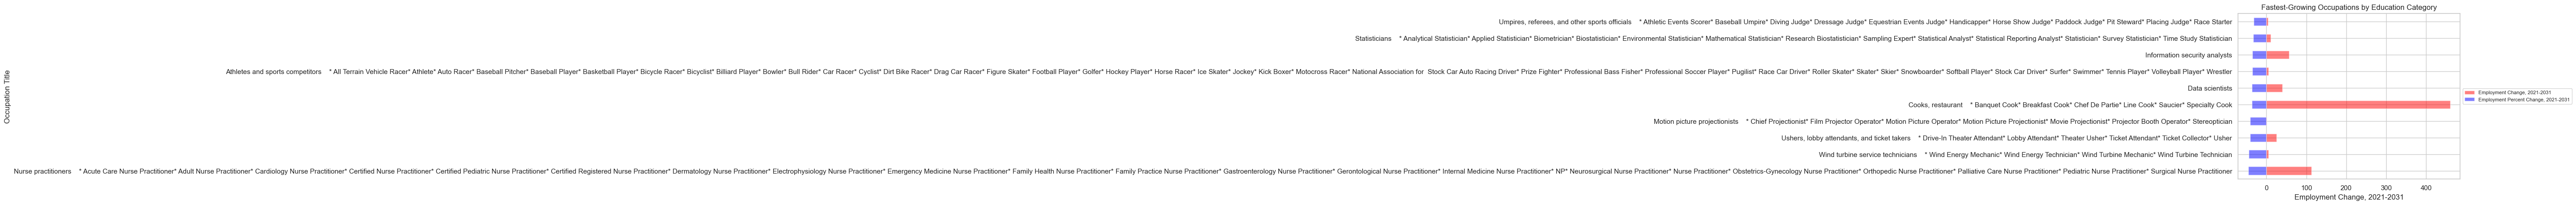

In [292]:
# sort values descending %
top_jobs_df = new_proj_df.sort_values(['Employment Percent Change, 2021-2031'], ascending=False)

# select top 10 rows
top_jobs_df = top_jobs_df.head(10)

# extract x values
x_col = top_jobs_df['Employment Percent Change, 2021-2031']

# create the plot
fig, ax = plt.subplots()
top_jobs_df['Employment Change, 2021-2031'].plot(kind='barh', ax=ax, color='red', alpha=0.5)
top_jobs_df['Employment Percent Change, 2021-2031'].mul(-1).plot(kind='barh', ax=ax, color='blue', alpha=0.5)

# set the x-tick positions and labels
xticks_pos = range(len(top_jobs_df))
xticks_labels = top_jobs_df['Occupation Title'].tolist()
ax.set_yticks(xticks_pos)
ax.set_yticklabels(xticks_labels, rotation=0)

# add axis labels and a title
ax.set_xlabel('Employment Change, 2021-2031')
ax.set_ylabel('Occupation Title')
plt.title('Fastest-Growing Occupations by Education Category')

# add a legend
plt.legend(['Employment Change, 2021-2031', 'Employment Percent Change, 2021-2031'], loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':8})

# save the plot to an HTML file
plt.savefig('empl_change.png')

In [267]:
# Sort the dataframe by 'Employment Change, 2021-2031' column
top_jobs_df = new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=False)

# Get the top 10 rows
top_jobs_df = top_jobs_df.head(10)

# Convert the first dataframe to an HTML table
html_table_top = top_jobs_df.head(10).to_html(index=False, max_rows=None, max_cols=None, table_id='TopJobs')

# Set the column widths
col_widths = [0.3, 0.7]

# Display the HTML table

#display(HTML(html_table_top))

#with open("top_jobs_table.html", "w") as file:
#    file.write(html_table_top)


In [293]:
#sort values descending %
top_jobs_df=new_proj_df.sort_values(['Employment Percent Change, 2021-2031'], ascending=False)
top_jobs_df.head(10)

# Convert the first dataframe to an HTML table
html_table_top_perc = top_jobs_df.head(10).to_html(index=False, max_rows=None, max_cols=None, table_id='TopJobs%')

# Set the column widths
col_widths = [0.3, 0.7]

# Concatenate the HTML tables
html_tables = html_table_top + html_table_top_perc
# Display the HTML table

display(HTML(html_tables))

with open("tables.html", "w") as file:
    file.write(html_table_top)


Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
Home health and personal care aides,924.0,25.4,"29,430",High school diploma or equivalent
"Cooks, restaurant * Banquet Cook* Breakfast Cook* Chef De Partie* Line Cook* Saucier* Specialty Cook",459.9,36.6,"30,010",No formal educational credential
Software developers,370.6,26.0,"120,730",Bachelor's degree
Fast food and counter workers,243.2,7.6,"25,100",No formal educational credential
General and operations managers * Department Store General Manager* General Manager* General Superintendent* Manufacturing Operations Manager* Operations Manager* Radio Station Manager* Television Station Manager,209.8,6.7,"97,970",Bachelor's degree
Waiters and waitresses * Cocktail Server* Cocktail Waitress* Dining Car Server* Restaurant Server* Wine Steward,197.0,10.3,"26,000",No formal educational credential
Registered nurses * CCU Nurse* CNS* Clinical Nurse Specialist* Community Health Nurse* Coronary Care Unit Nurse* Emergency Room RN* Endoscopy Registered Nurse* Hospice Registered Nurse* Obstetrical Nurse* Oncology Registered Nurse* PACU Nurse* Pediatric Registered Nurse* Post-Anesthesia Care Unit Nurse* Psychiatric Nurse* RN* Registered Nurse* Triage Registered Nurse,195.4,6.2,"77,600",Bachelor's degree
"Laborers and freight, stock, and material movers, hand * Cargo Handler* Cart Pusher* Freight Handler* Grave Digger* Manufacturing Laborer* Material Handler* Package Handler* Shipping and Receiving Material Handler* Stock Mover* Van Loader* Wharf Laborer",168.4,6.0,"31,230",No formal educational credential
Stockers and order fillers,157.9,6.4,"30,110",High school diploma or equivalent
Market research analysts and marketing specialists * Market Research Analyst* Market Research Specialist* Marketing Analyst* Marketing Consultant* Marketing Forecaster* Marketing Specialist,150.3,19.0,"63,920",Bachelor's degree


In [233]:
#sort values ascending
top_jobs_df=new_proj_df.sort_values(['Employment Change, 2021-2031'], ascending=True)
top_jobs_df.reset_index(drop=True).head(10)

,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Cashiers * Cash Register Operator* Check Ou...,-335.7,-10.0,"27,260",No formal educational credential
1,"Secretaries and administrative assistants, exc...",-207.6,-10.0,"37,880",High school diploma or equivalent
2,"Office clerks, general * Administrative Cle...",-130.8,-4.8,"37,030",High school diploma or equivalent
3,Customer service representatives * Complain...,-105.3,-3.6,"36,920",High school diploma or equivalent
4,Executive secretaries and executive administra...,-102.6,-20.2,"62,060",High school diploma or equivalent
5,Miscellaneous assemblers and fabricators,-96.4,-7.1,"36,590",High school diploma or equivalent
6,First-line supervisors of retail sales workers...,-78.2,-5.2,"39,230",High school diploma or equivalent
7,"Bookkeeping, accounting, and auditing clerks ...",-77.2,-4.5,"45,560","Some college, no degree"
8,"Cooks, fast food * Fast Food Cook* Fast Foo...",-69.1,-8.7,"24,180",No formal educational credential
9,"Shipping, receiving, and inventory clerks *...",-57.1,-7.0,"36,890",High school diploma or equivalent


In [234]:
#sort values ascending
top_jobs_df=new_proj_df.sort_values(['Employment Percent Change, 2021-2031'], ascending=True)
top_jobs_df.reset_index(drop=True).head(10)

,Occupation Title,"Employment Change, 2021-2031","Employment Percent Change, 2021-2031",Median Annual Wage 2021,Typical Entry-Level Education
0,Word processors and typists * Clerk Typist*...,-17.6,-38.2,"44,030",High school diploma or equivalent
1,Parking enforcement workers * Meter Maid* P...,-3.2,-37.1,"46,590",High school diploma or equivalent
2,"Cutters and trimmers, hand * Fur Trimmer* H...",-2.3,-28.4,"30,230",No formal educational credential
3,Nuclear power reactor operators * Nuclear C...,-1.3,-26.8,"104,260",High school diploma or equivalent
4,Print binding and finishing workers * Binde...,-10.5,-24.8,"36,590",High school diploma or equivalent
5,Watch and clock repairers * Antique Clock R...,-0.5,-24.7,"44,250",High school diploma or equivalent
6,Data entry keyers * Customs Entry Clerk* Da...,-38.5,-24.7,"35,630",High school diploma or equivalent
7,Telephone operators * 411 Directory Assista...,-1.0,-24.5,"37,630",High school diploma or equivalent
8,"Switchboard operators, including answering ser...",-11.8,-24.0,"30,150",High school diploma or equivalent
9,"Electronic equipment installers and repairers,...",-2.2,-23.4,"40,670",High school diploma or equivalent


In [235]:
# Load the project data
new_proj_df = pd.read_csv("Employment Projections.csv")

# Define the function to update the table based on the user input
def update_table(change):
    value = change['new']
    print(f"Filtering by value: {value}")
    filtered = new_proj_df[new_proj_df['Occupation Title'].str.contains(value, case=False)]
    print(filtered.head()) # print the first 5 rows of the filtered DataFrame for debugging
    table_html = filtered.to_html(index=False)
    table.value = table_html

# Create a text box for the user input
search_box = widgets.Text(placeholder='Search by occupation title')

# Call the update_table function when the user input changes
search_box.observe(update_table, names='value')

# Create the initial table
table_html = new_proj_df.to_html(index=False)
table = widgets.HTML(value=table_html)

# Display the search box and the table
display(search_box)
display(table)


Text(value='', placeholder='Search by occupation title')

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Oc…

Filtering by value: a
                                    Occupation Title Occupation Code  \
0  Accountants and auditors    * Account Auditor*...         13-2011   
1  Actors    * Actor Understudy* Actress* Dramati...         27-2011   
2  Actuaries    * Actuarial Associate* Actuarial ...         15-2011   
3                                     Acupuncturists         29-1291   
4  Adhesive bonding machine operators and tenders...         51-9191   

  Employment 2021 Employment 2031  Employment Change, 2021-2031  \
0        1,449.80        1,531.60                          81.8   
1            50.6            54.7                           4.1   
2            28.3            34.2                           5.9   
3            23.7            24.6                           0.9   
4            12.7            12.9                           0.2   

   Employment Percent Change, 2021-2031  \
0                                   5.6   
1                                   8.2   
2            

Filtering by value: acccou
Empty DataFrame
Columns: [Occupation Title, Occupation Code, Employment 2021, Employment 2031, Employment Change, 2021-2031, Employment Percent Change, 2021-2031, Occupational Openings, 2021-2031 Annual Average, Median Annual Wage 2021, Typical Entry-Level Education, Education Code, Work Experience in a Related Occupation, Workex Code, Typical on-the-job Training, trCode]
Index: []
Filtering by value: accco
Empty DataFrame
Columns: [Occupation Title, Occupation Code, Employment 2021, Employment 2031, Employment Change, 2021-2031, Employment Percent Change, 2021-2031, Occupational Openings, 2021-2031 Annual Average, Median Annual Wage 2021, Typical Entry-Level Education, Education Code, Work Experience in a Related Occupation, Workex Code, Typical on-the-job Training, trCode]
Index: []
Filtering by value: accc
Empty DataFrame
Columns: [Occupation Title, Occupation Code, Employment 2021, Employment 2031, Employment Change, 2021-2031, Employment Percent Change, 

Filtering by value: accoun
                                     Occupation Title Occupation Code  \
0   Accountants and auditors    * Account Auditor*...         13-2011   
9   Advertising sales agents    * Advertising Acco...         41-3011   
65  Bill and account collectors    * Accounts Coll...         43-3011   
66  Billing and posting clerks    * Billing Clerk*...         43-3021   
73  Bookkeeping, accounting, and auditing clerks  ...         43-3031   

   Employment 2021 Employment 2031  Employment Change, 2021-2031  \
0         1,449.80        1,531.60                          81.8   
9            100.7            92.7                          -8.0   
65           215.4           197.9                         -17.5   
66           445.3             450                           4.7   
73        1,707.80        1,630.60                         -77.2   

    Employment Percent Change, 2021-2031  \
0                                    5.6   
9                                   -

Filtering by value: a
                                    Occupation Title  \
0  Accountants and auditors    * Account Auditor*...   
1  Actors    * Actor Understudy* Actress* Dramati...   
2  Actuaries    * Actuarial Associate* Actuarial ...   
3                                     Acupuncturists   
4  Adhesive bonding machine operators and tenders...   

   Employment Change, 2021-2031  Employment Percent Change, 2021-2031  \
0                          81.8                                   5.6   
1                           4.1                                   8.2   
2                           5.9                                  20.8   
3                           0.9                                   3.9   
4                           0.2                                   1.5   

  Median Annual Wage 2021      Typical Entry-Level Education  
0                  77,250                  Bachelor's degree  
1                     NaN            Some college, no degree  
2            

Filtering by value: accounti
                                     Occupation Title  \
73  Bookkeeping, accounting, and auditing clerks  ...   
85  Business teachers, postsecondary    * Accounti...   

    Employment Change, 2021-2031  Employment Percent Change, 2021-2031  \
73                         -77.2                                  -4.5   
85                           6.4                                   6.2   

   Median Annual Wage 2021    Typical Entry-Level Education  
73                  45,560          Some college, no degree  
85                  94,360  Doctoral or professional degree  
Filtering by value: accountin
                                     Occupation Title  \
73  Bookkeeping, accounting, and auditing clerks  ...   
85  Business teachers, postsecondary    * Accounti...   

    Employment Change, 2021-2031  Employment Percent Change, 2021-2031  \
73                         -77.2                                  -4.5   
85                           6.4        

Filtering by value: 
                                    Occupation Title  \
0  Accountants and auditors    * Account Auditor*...   
1  Actors    * Actor Understudy* Actress* Dramati...   
2  Actuaries    * Actuarial Associate* Actuarial ...   
3                                     Acupuncturists   
4  Adhesive bonding machine operators and tenders...   

   Employment Change, 2021-2031  Employment Percent Change, 2021-2031  \
0                          81.8                                   5.6   
1                           4.1                                   8.2   
2                           5.9                                  20.8   
3                           0.9                                   3.9   
4                           0.2                                   1.5   

  Median Annual Wage 2021      Typical Entry-Level Education  
0                  77,250                  Bachelor's degree  
1                     NaN            Some college, no degree  
2             

In [304]:
#series
headers = {'Content-type': 'application/json'} #contains info about the message- such as destination

# Submit the list of series as data - payload actual data being transmitted over a network
data = json.dumps({"seriesid": ['CUSR0000SA0',#CPI for All Urban Consumers (CPI-U)
                                                               ], 
                   'startyear':'2010', 'endyear':'2023',
                   'catalog':True,
                   'annualaverage':True,
                   "registrationkey": api_key_bls}, indent=4)
p2 = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
p2.json()

{'status': 'REQUEST_SUCCEEDED',
 'responseTime': 270,
 'message': [],
 'Results': {'series': [{'seriesID': 'CUSR0000SA0',
    'catalog': {'series_title': 'All items in U.S. city average, all urban consumers, seasonally adjusted',
     'series_id': 'CUSR0000SA0',
     'seasonality': 'Seasonally Adjusted',
     'survey_name': 'CPI for All Urban Consumers (CPI-U)',
     'survey_abbreviation': 'CU',
     'measure_data_type': 'All items',
     'area': 'U.S. city average',
     'item': 'All items'},
    'data': [{'year': '2023',
      'period': 'M02',
      'periodName': 'February',
      'latest': 'true',
      'value': '301.648',
      'footnotes': [{}]},
     {'year': '2023',
      'period': 'M01',
      'periodName': 'January',
      'value': '300.536',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M12',
      'periodName': 'December',
      'value': '298.990',
      'footnotes': [{}]},
     {'year': '2022',
      'period': 'M11',
      'periodName': 'November',
      

In [307]:
#create a list to create a DF

list_columns= []


for series in json_data['Results']['series']:

     
    seriesId = series['seriesID']
    print(seriesId)
    
    if 'catalog' in series.keys():
        seasonality = series['catalog']['seasonality']
        survey_name = series['catalog']['survey_name']
        measure_data_type = series['catalog']['measure_data_type']
        item = series['catalog']['item']
            
        if 'commerce_industry' in series['catalog'].keys():
            commerce_industry = series['catalog']['commerce_industry']
            
        else:
            commerce_industry = None
            
            
        if 'commerce_sector' in series['catalog'].keys():
            commerce_sector = series['catalog']['commerce_sector']
        else:
            commerce_sector = None
     
        if 'area' in series['catalog'].keys():
            area = series['catalog']['area']
        else:
            area = None
    
    
    
       # area= series['catalog']['area']
    else:
        seasonality = None
        survey_name = None
        measure_data_type = None
        commerce_industry = None
        commerce_sector = None
        area= None
    #add all variables & create a list to append to the list above
    
    
    for item in series['data']:
        year = item['year']
        period = item['period']
        periodName = item['periodName']
        value = item['value']
        
        
        list_columns.append([seriesId,seasonality,survey_name,measure_data_type,
                             commerce_industry,commerce_sector,item,area,year,period,periodName,value])
        
inflation_df= pd.DataFrame(list_columns,columns=['seriesId','seasonality','survey_name','measure_data_type',
                             'commerce_industry','commerce_sector','item','area','year','period','periodName','value'])


inflation_df.to_csv("inflation.csv", index= False, header=True)




CUSR0000SA0


In [366]:
inflation_df.columns

Index(['seriesId', 'seasonality', 'survey_name', 'measure_data_type',
       'commerce_industry', 'commerce_sector', 'item', 'area', 'year',
       'period', 'periodName', 'value'],
      dtype='object')

In [367]:
#change column value to Integer
inflation_df['value'] = inflation_df['value'].apply(lambda x:float(x))

In [369]:
new_infl_df_pivot = inflation_df.pivot_table(index=['year'], columns='periodName', values='value')
new_infl_df_pivot()

TypeError: 'DataFrame' object is not callable

In [347]:
# pitot the data plot 
# https://data.bls.gov/timeseries/CUSR0000SA0&output_view=pct_1mth
new_infl_df_pivot = inflation_df.pivot_table(index=['year'], columns='periodName', values='value')
infl_df_pivot = new_infl_df_pivot.rename(columns{'Jnuary':'Jan', 'February':'Feb', 
                                                  'March':'Mar', 'April': 'Apr',
                                                  'May':'May', 'June':'Jun', 'July':'Jul', 
                                                  'August':'Aug', 'September':'Sep', 'October':'Oct', 
                                                  'November':'Nov', 'December':'Dec'})
infl_df_pivot

SyntaxError: invalid syntax (981021877.py, line 4)

In [336]:
#https://data.bls.gov/timeseries/CUSR0000SA0&output_view=pct_1mth
    
fig_infl = px.line(new_bed_df_pivot, x='year', y=['Gross Job Gains', 'Gross Job Losses'])
fig_infl.update_traces(mode='lines+markers', hovertemplate='Year=%{x}<br>Value=%{y:.0f}<extra></extra>')
fig_infl.update_layout(title='Gross job for the total private sector in the U.S.',
                  xaxis_title='Year', yaxis_title='Number of Jobs', hovermode='x')
pio.write_html(fig_infl, file='fig_infl_plot.html', auto_open=True)
fig_infl.show()